In [1]:
import torch
import matplotlib.pyplot as plt

## **Просмотр датасета**

In [3]:
#!g1.1
import torchvision.transforms as T
from torchvision.datasets import OxfordIIITPet

dataset = OxfordIIITPet('/home/jupyter/mnt/datasets/pets', download=True, target_types='segmentation')

100%|██████████| 792M/792M [00:59<00:00, 13.3MB/s] 


Extracting /home/jupyter/mnt/datasets/pets/oxford-iiit-pet/images.tar.gz to /home/jupyter/mnt/datasets/pets/oxford-iiit-pet


100%|██████████| 19.2M/19.2M [00:02<00:00, 7.80MB/s]


Extracting /home/jupyter/mnt/datasets/pets/oxford-iiit-pet/annotations.tar.gz to /home/jupyter/mnt/datasets/pets/oxford-iiit-pet


In [4]:
dataset[0]

(<PIL.Image.Image image mode=RGB size=394x500>,
 <PIL.PngImagePlugin.PngImageFile image mode=L size=394x500>)

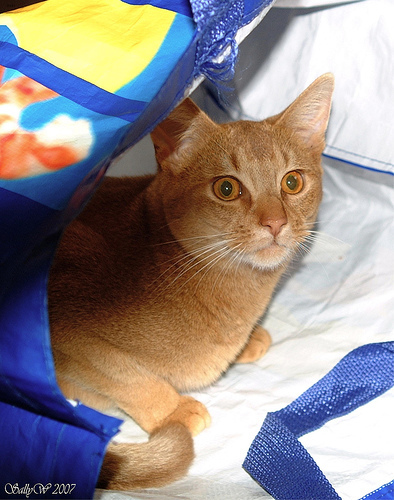

In [5]:
dataset[0][0]

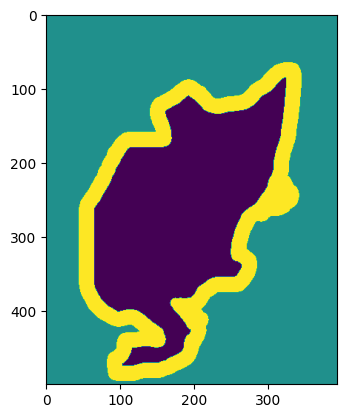

In [6]:
plt.imshow(dataset[0][1])

## **Создание трансформеров и dataloader**

In [8]:
transform = T.Compose(
    [
        T.Resize((128, 128)),
        T.ToTensor(),
    ]
)

target_transform = T.Compose(
    [
        T.Resize((128, 128)),
        T.PILToTensor(),
        T.Lambda(lambda x: (x - 1).long())
    ]
)

train_dataset = OxfordIIITPet('/home/jupyter/mnt/datasets/pets', transform=transform, target_transform=target_transform, target_types='segmentation')
valid_dataset = OxfordIIITPet('/home/jupyter/mnt/datasets/pets', transform=transform, split='test', target_transform=target_transform, target_types='segmentation')

In [10]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=True, num_workers=4, pin_memory=True)

## **Функции для обучения, инфренса и визуализации**

In [11]:
from tqdm import tqdm

def train(model) -> float:
    model.train()

    train_loss = 0
    total = 0
    correct = 0

    for x, y in tqdm(train_loader, desc='Train'):
        bs = y.size(0)

        x, y = x.to(device), y.squeeze(1).to(device)

        optimizer.zero_grad()

        output = model(x)

        loss = loss_fn(output.reshape(bs, 3, -1), y.reshape(bs, -1))

        train_loss += loss.item()

        loss.backward()

        optimizer.step()

        _, y_pred = output.max(dim=1)
        total += y.size(0) * y.size(1) * y.size(2)
        correct += (y == y_pred).sum().item()

    train_loss /= len(train_loader)
    accuracy = correct / total

    return train_loss, accuracy

In [12]:
@torch.inference_mode()
def evaluate(model, loader) -> tuple[float, float]:
    model.eval()

    total_loss = 0
    total = 0
    correct = 0

    for x, y in tqdm(loader, desc='Evaluation'):
        bs = y.size(0)

        x, y = x.to(device), y.squeeze(1).to(device)

        output = model(x)

        loss = loss_fn(output.reshape(bs, 3, -1), y.reshape(bs, -1))

        total_loss += loss.item()

        _, y_pred = output.max(dim=1)
        total += y.size(0) * y.size(1) * y.size(2)
        correct += (y == y_pred).sum().item()

    total_loss /= len(loader)
    accuracy = correct / total

    return total_loss, accuracy

In [13]:
from IPython.display import clear_output


def plot_stats(
    train_loss: list[float],
    valid_loss: list[float],
    train_accuracy: list[float],
    valid_accuracy: list[float],
    title: str
):
    plt.figure(figsize=(16, 8))

    plt.title(title + ' loss')

    plt.plot(train_loss, label='Train loss')
    plt.plot(valid_loss, label='Valid loss')
    plt.legend()
    plt.grid()

    plt.show()

    plt.figure(figsize=(16, 8))

    plt.title(title + ' accuracy')
    
    plt.plot(train_accuracy, label='Train accuracy')
    plt.plot(valid_accuracy, label='Valid accuracy')
    plt.legend()
    plt.grid()

    plt.show()

In [14]:
import numpy as np
from PIL import Image


@torch.inference_mode()
def visualize(model, batch):
    model.eval()

    xs, ys = batch
    
    to_pil = T.ToPILImage()

    for i, (x, y) in enumerate(zip(xs, ys)):
        prediction = model(x.unsqueeze(0).cuda()).squeeze(0).max(dim=0)[1]

        fig, ax = plt.subplots(1, 3, figsize=(24, 8), facecolor='white')

        ax[0].imshow(to_pil(x))
        ax[1].imshow(to_pil(y.to(torch.uint8)))
        ax[2].imshow(to_pil(prediction.to(torch.uint8)))

        ax[0].axis('off')
        ax[1].axis('off')
        ax[2].axis('off')

        ax[0].set_title('Original image')
        ax[1].set_title('Segmentation mask')
        ax[2].set_title('Prediction')

        plt.subplots_adjust(wspace=0, hspace=0.1)
        plt.show()

        if i >= 9:
            break

In [15]:
def whole_train_valid_cycle(model, num_epochs, title):
    train_loss_history, valid_loss_history = [], []
    train_accuracy_history, valid_accuracy_history = [], []

    for epoch in range(num_epochs):
        train_loss, train_accuracy = train(model)
        valid_loss, valid_accuracy = evaluate(model, valid_loader)

        train_loss_history.append(train_loss)
        valid_loss_history.append(valid_loss)

        train_accuracy_history.append(train_accuracy)
        valid_accuracy_history.append(valid_accuracy)

        clear_output()

        plot_stats(
            train_loss_history, valid_loss_history,
            train_accuracy_history, valid_accuracy_history,
            title
        )

        visualize(model, next(iter(valid_loader)))

## **Создание архитектуры сети и обучение**

In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F

def conv_plus_conv(in_channels: int, out_channels: int):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.LeakyReLU(0.2),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.LeakyReLU(0.2),
    )

class UNET(nn.Module):
    def __init__(self):
        super(UNET, self).__init__()

        base_channels = 16

        self.down1 = conv_plus_conv(3, base_channels)
        self.down2 = conv_plus_conv(base_channels, base_channels * 2)
        self.down3 = conv_plus_conv(base_channels * 2, base_channels * 4)

        self.bottleneck = conv_plus_conv(base_channels * 4, base_channels * 8)

        self.up3 = conv_plus_conv(base_channels * 8, base_channels * 4)
        self.up2 = conv_plus_conv(base_channels * 4, base_channels * 2)
        self.up1 = conv_plus_conv(base_channels * 2, base_channels)

        self.out = nn.Conv2d(base_channels, 3, kernel_size=1)

        self.downsample = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        # Downward pass (encoding)
        residual1 = self.down1(x)
        x = self.downsample(residual1)

        residual2 = self.down2(x)
        x = self.downsample(residual2)

        residual3 = self.down3(x)
        x = self.downsample(residual3)

        x = self.bottleneck(x)

        x = F.interpolate(x, scale_factor=2, mode='bilinear', align_corners=False)
        x = torch.cat((x, residual3), dim=1)
        x = self.up3(x)

        x = F.interpolate(x, scale_factor=2, mode='bilinear', align_corners=False)
        x = torch.cat((x, residual2), dim=1)
        x = self.up2(x)

        x = F.interpolate(x, scale_factor=2, mode='bilinear', align_corners=False)
        x = torch.cat((x, residual1), dim=1)
        x = self.up1(x)

        # Output layer
        x = self.out(x)

        return x


In [17]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(device)
print(torch.cuda.get_device_name())

loss_fn = nn.CrossEntropyLoss()

cuda:0
Tesla T4


In [18]:
from torch.optim import Adam

model = UNET().to(device)

optimizer = Adam(model.parameters(), lr=1e-3)

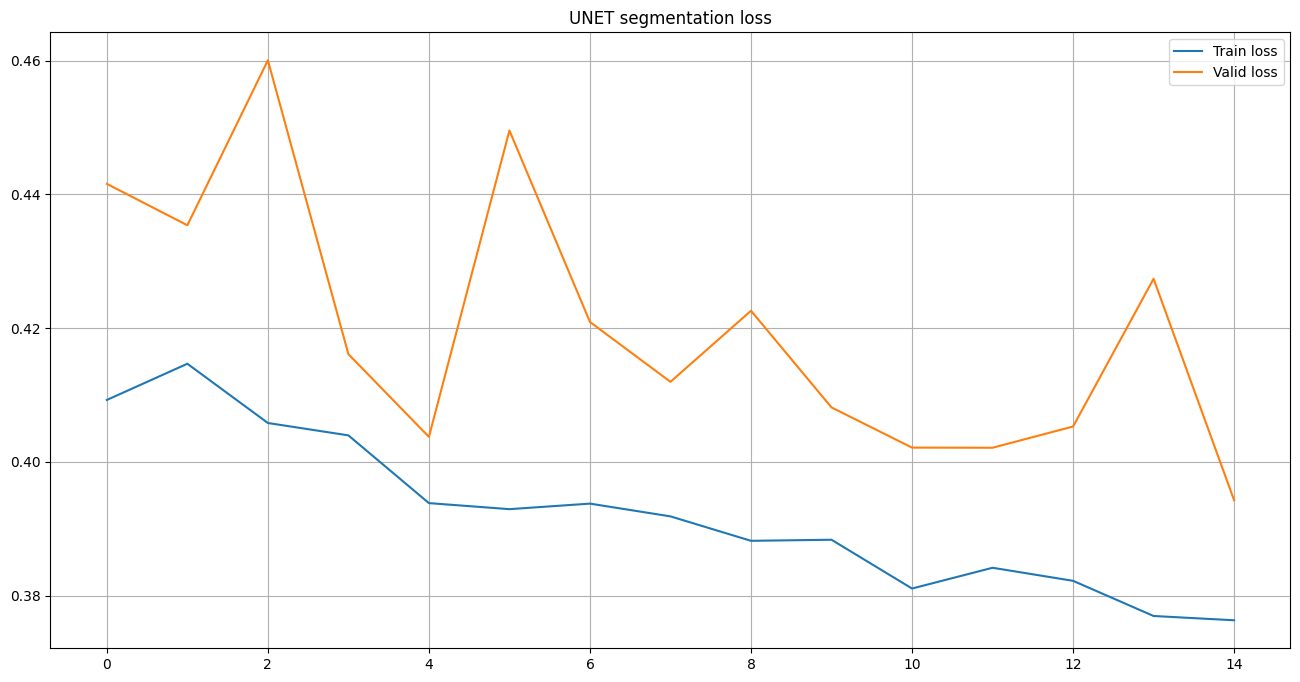

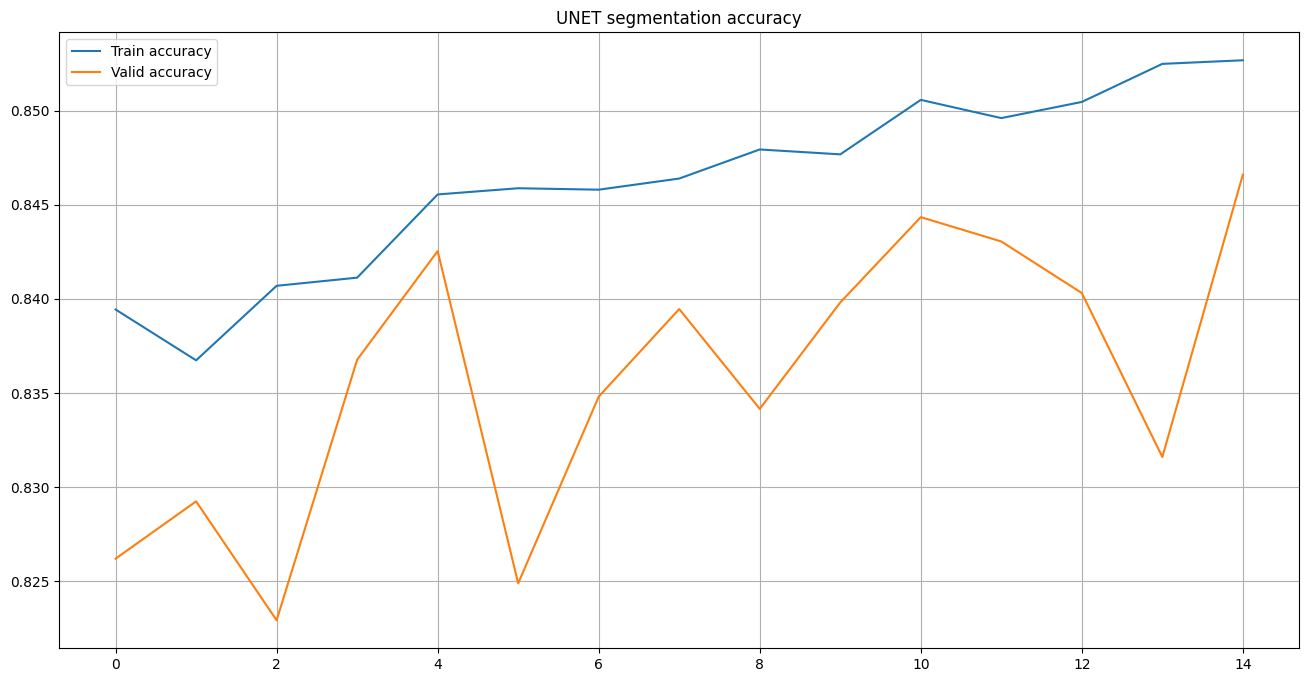

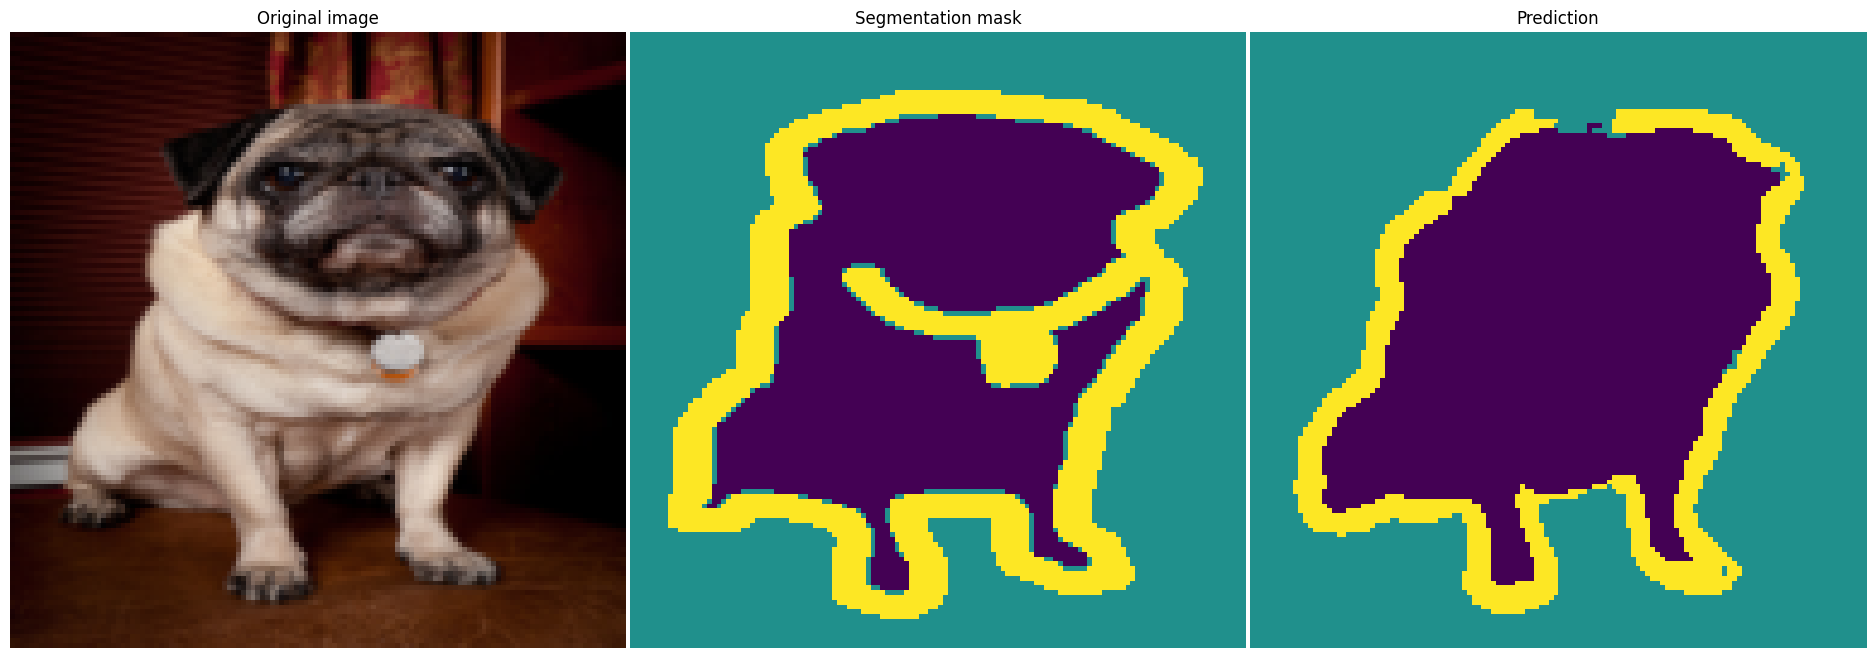

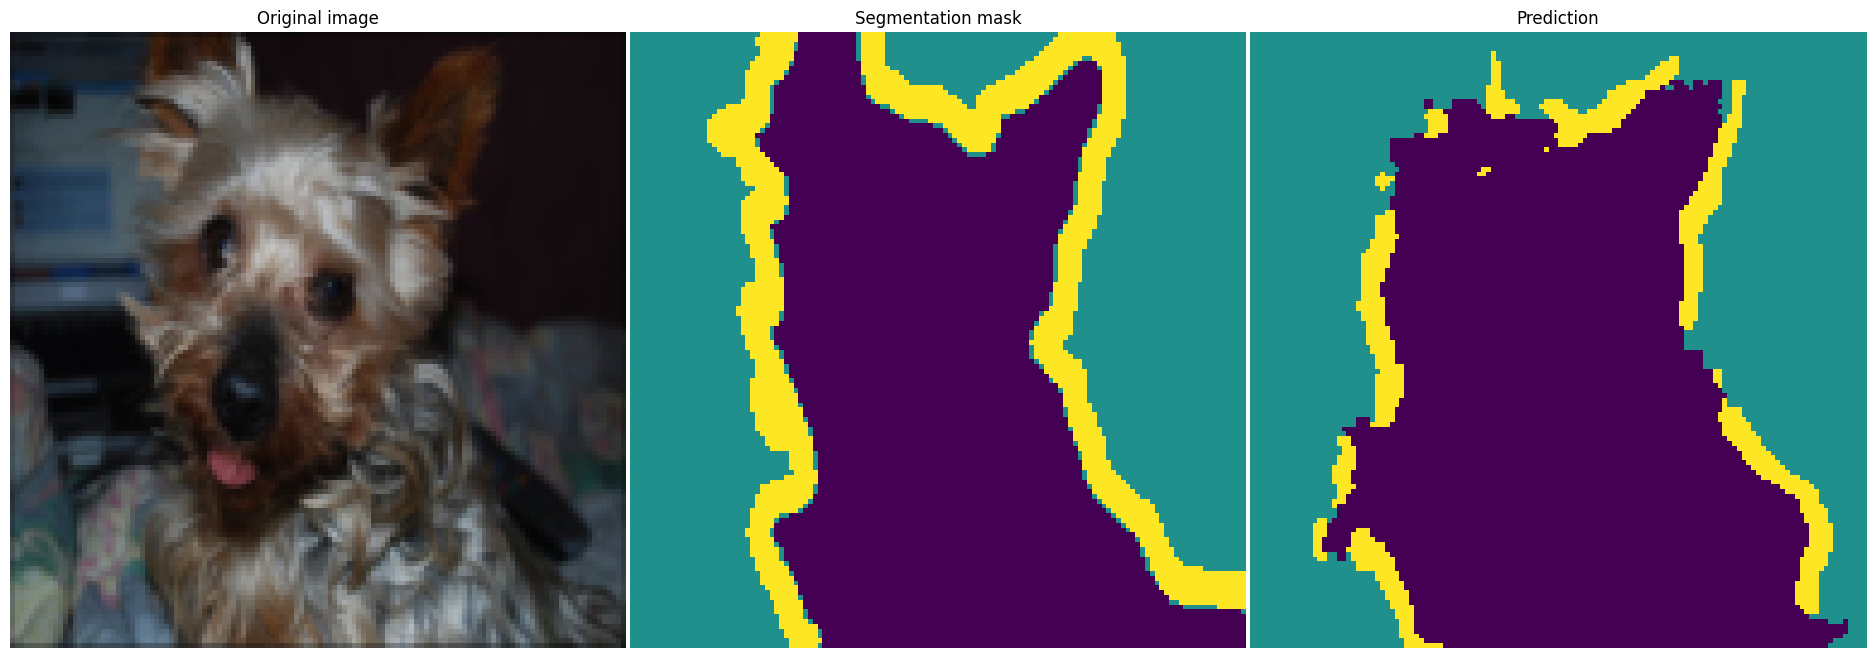

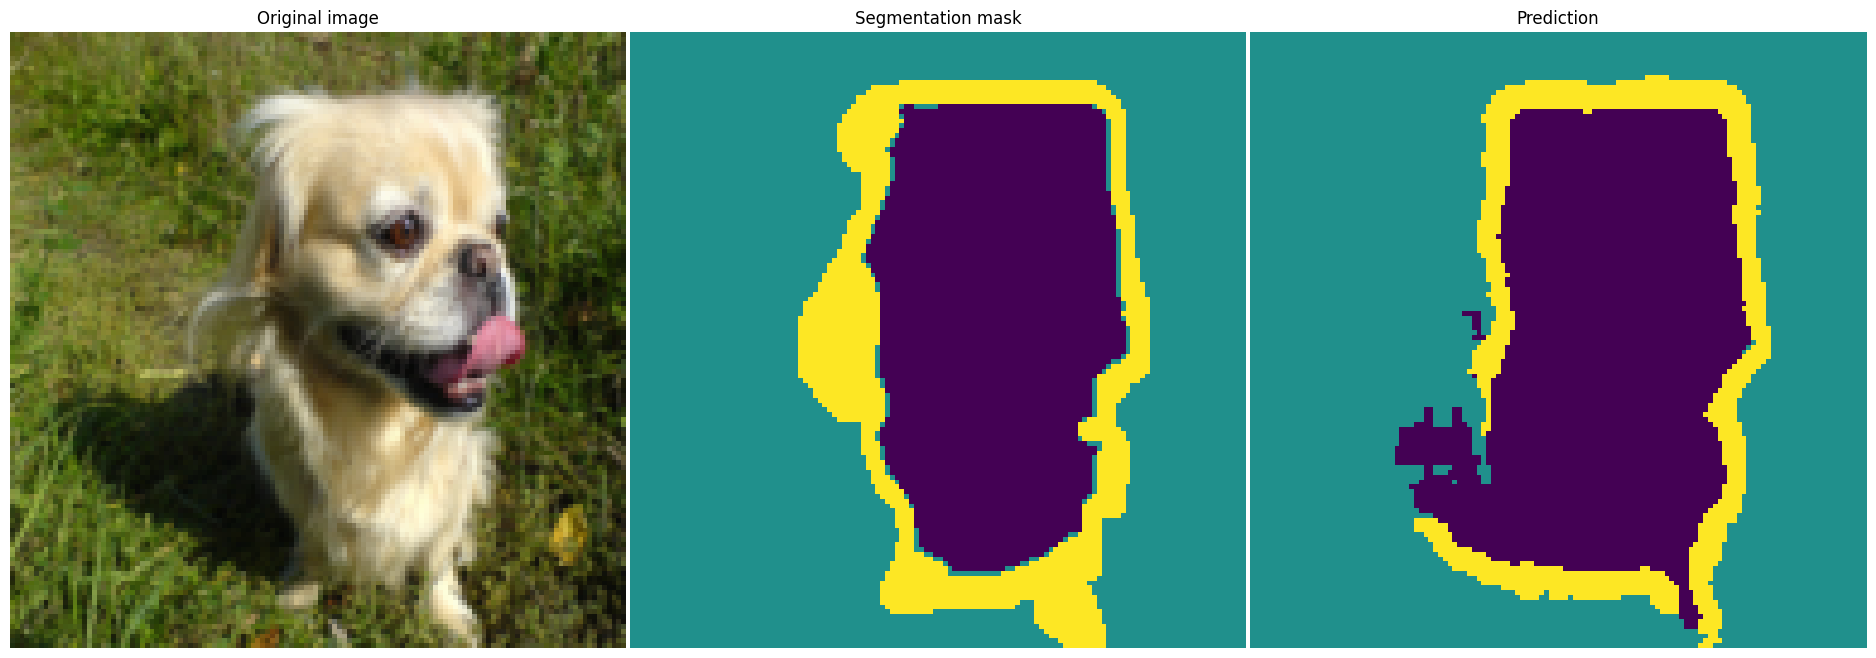

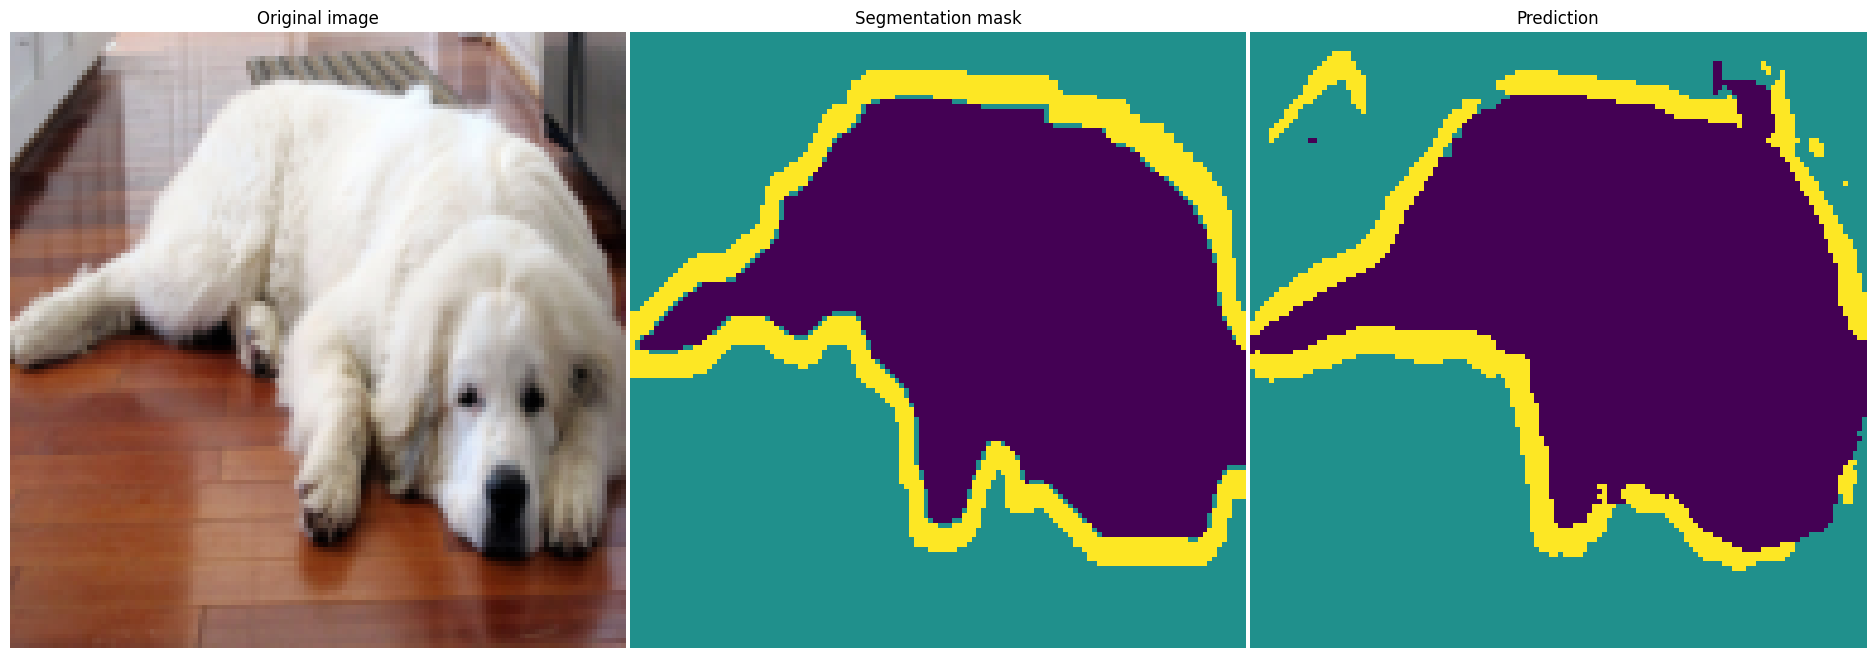

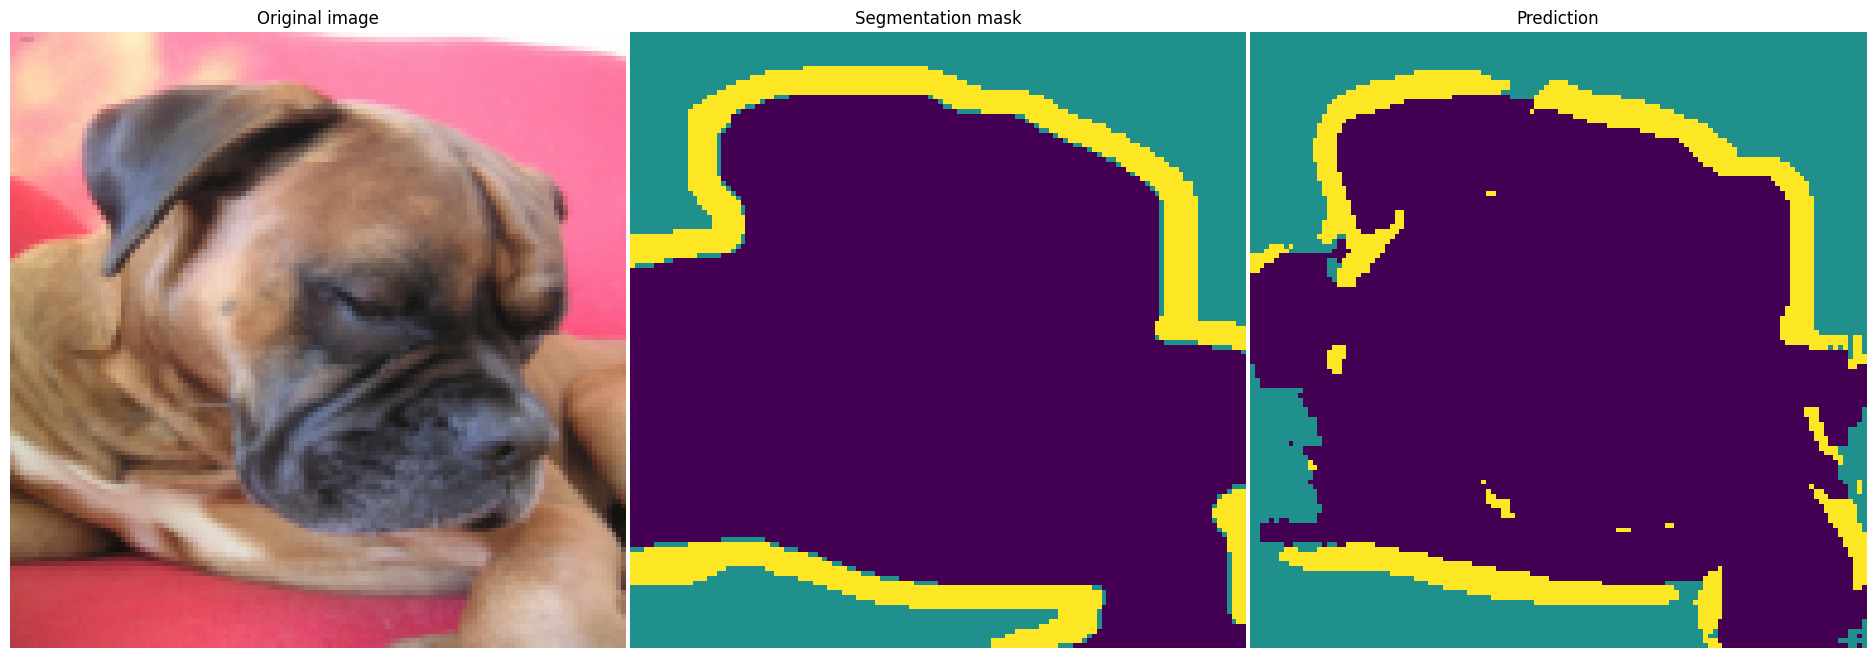

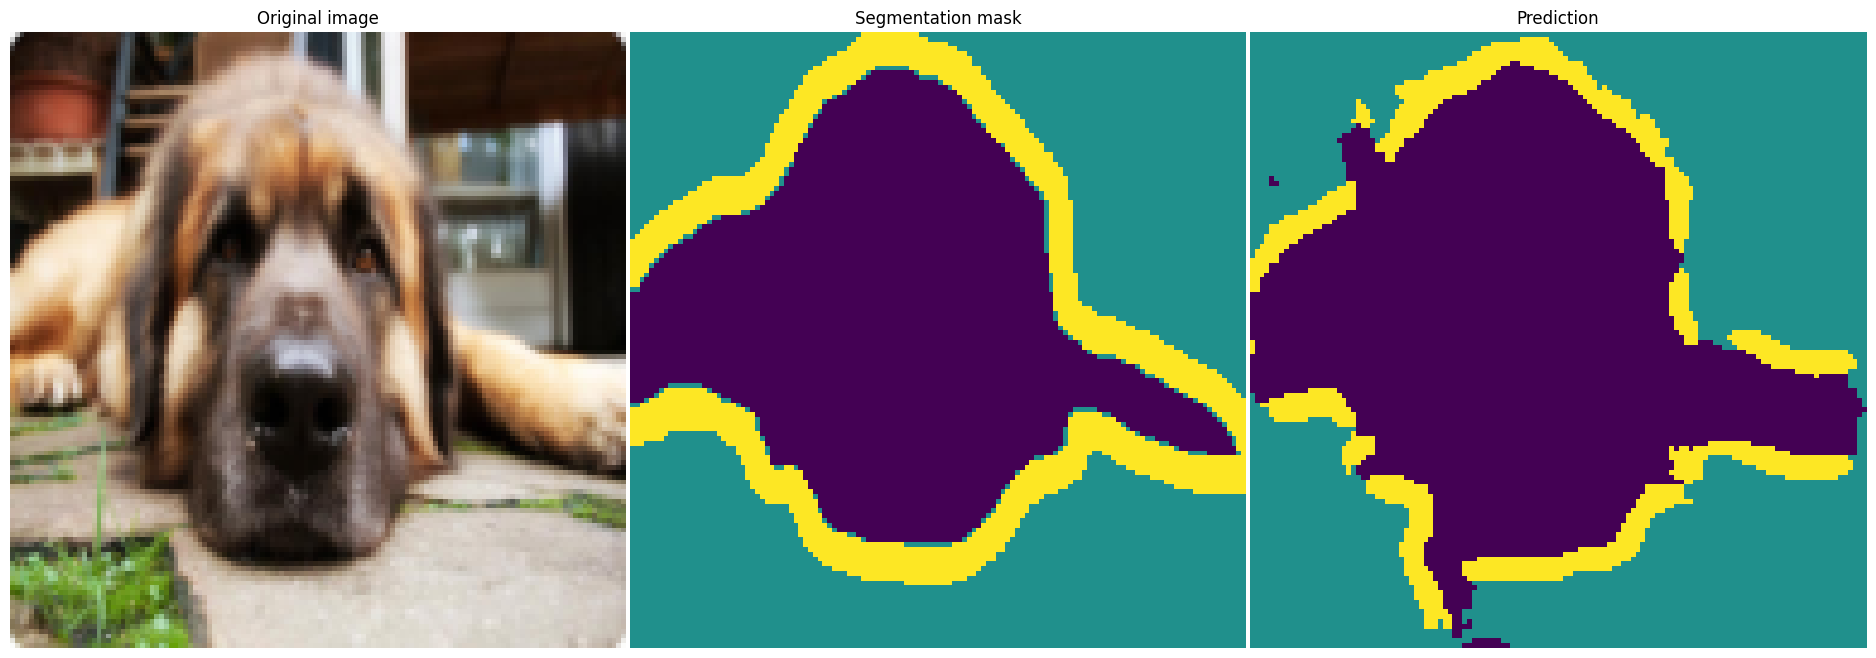

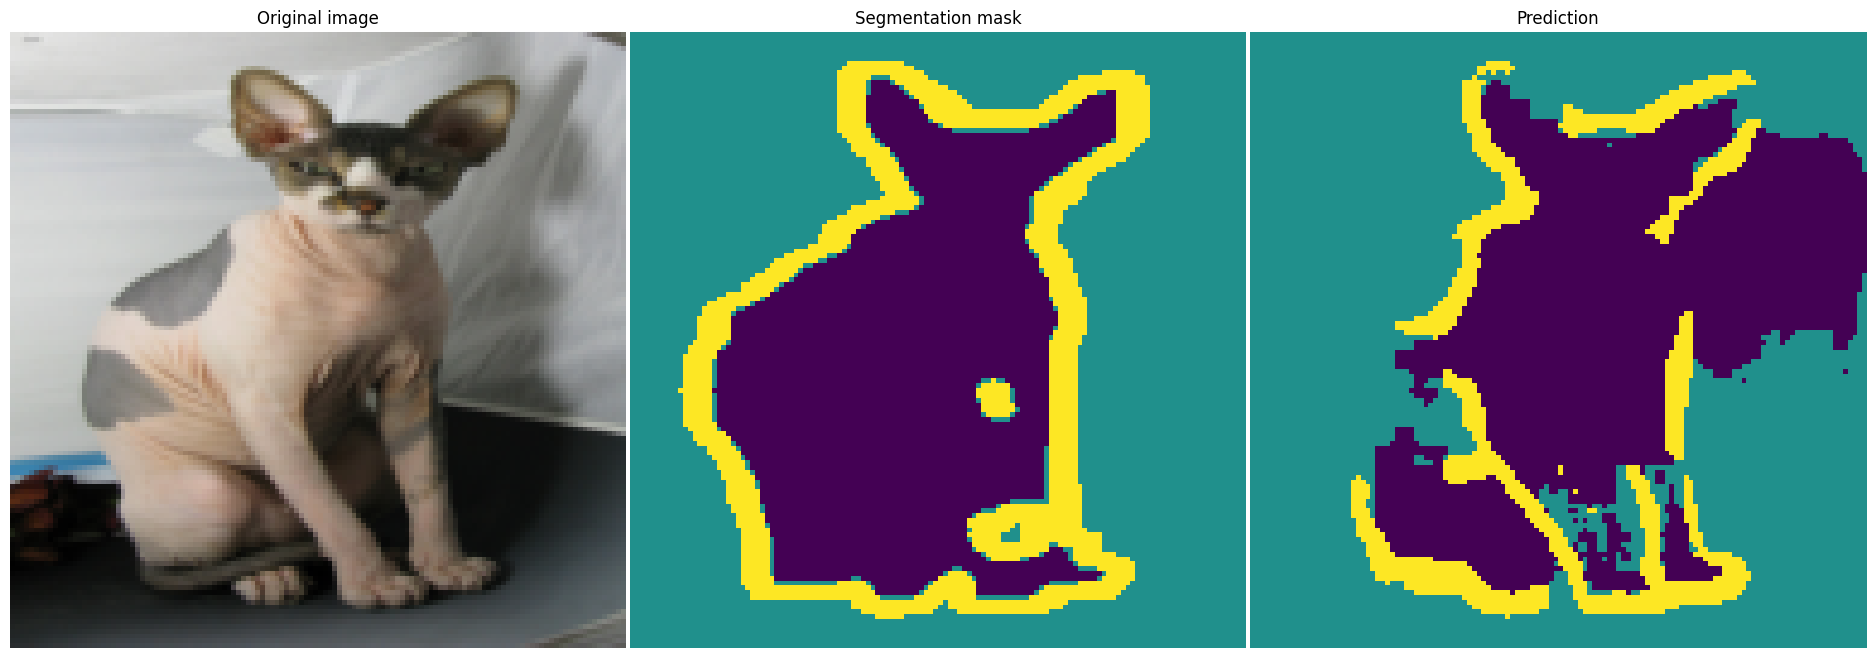

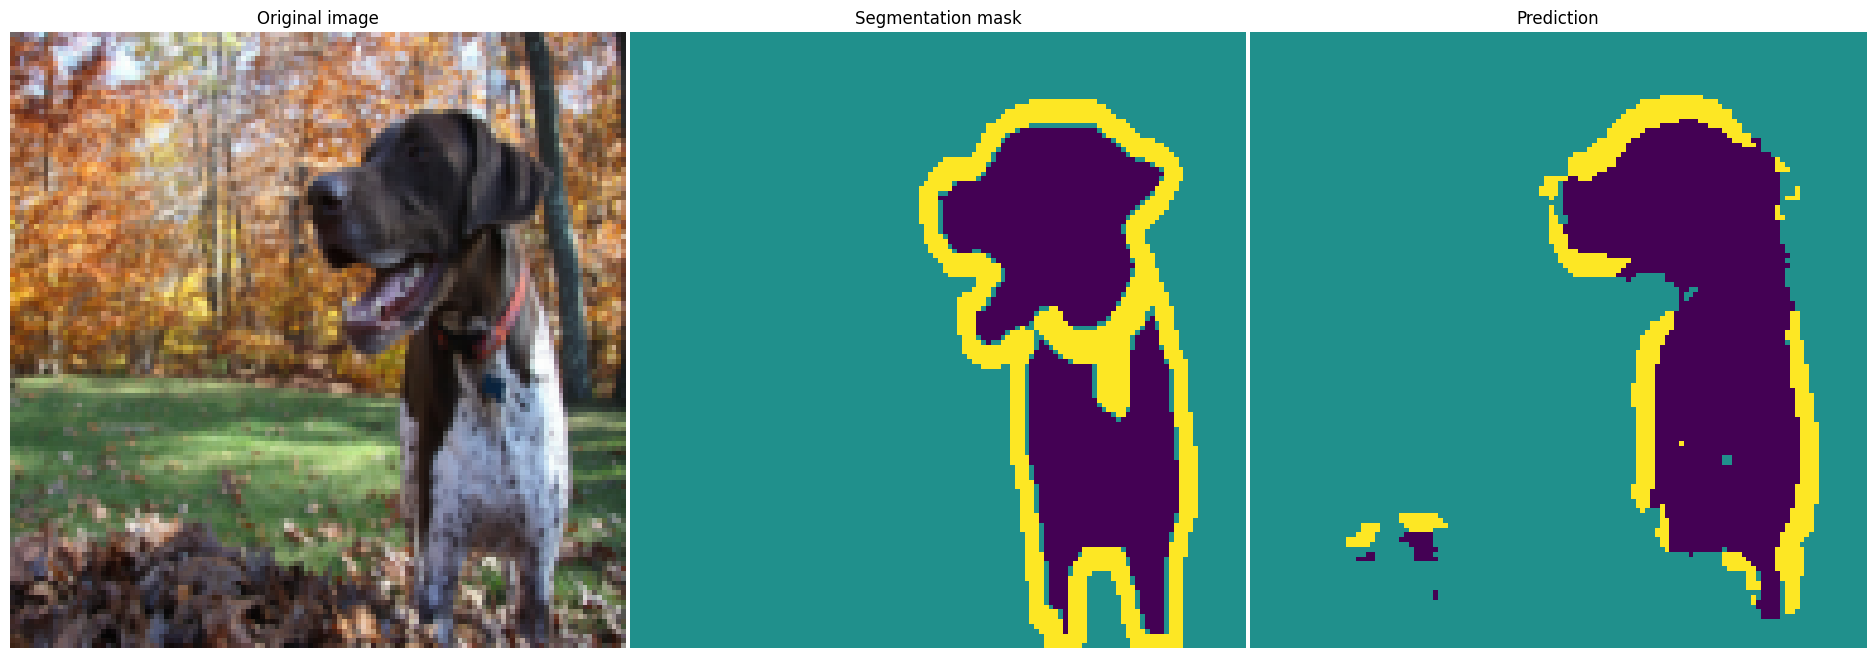

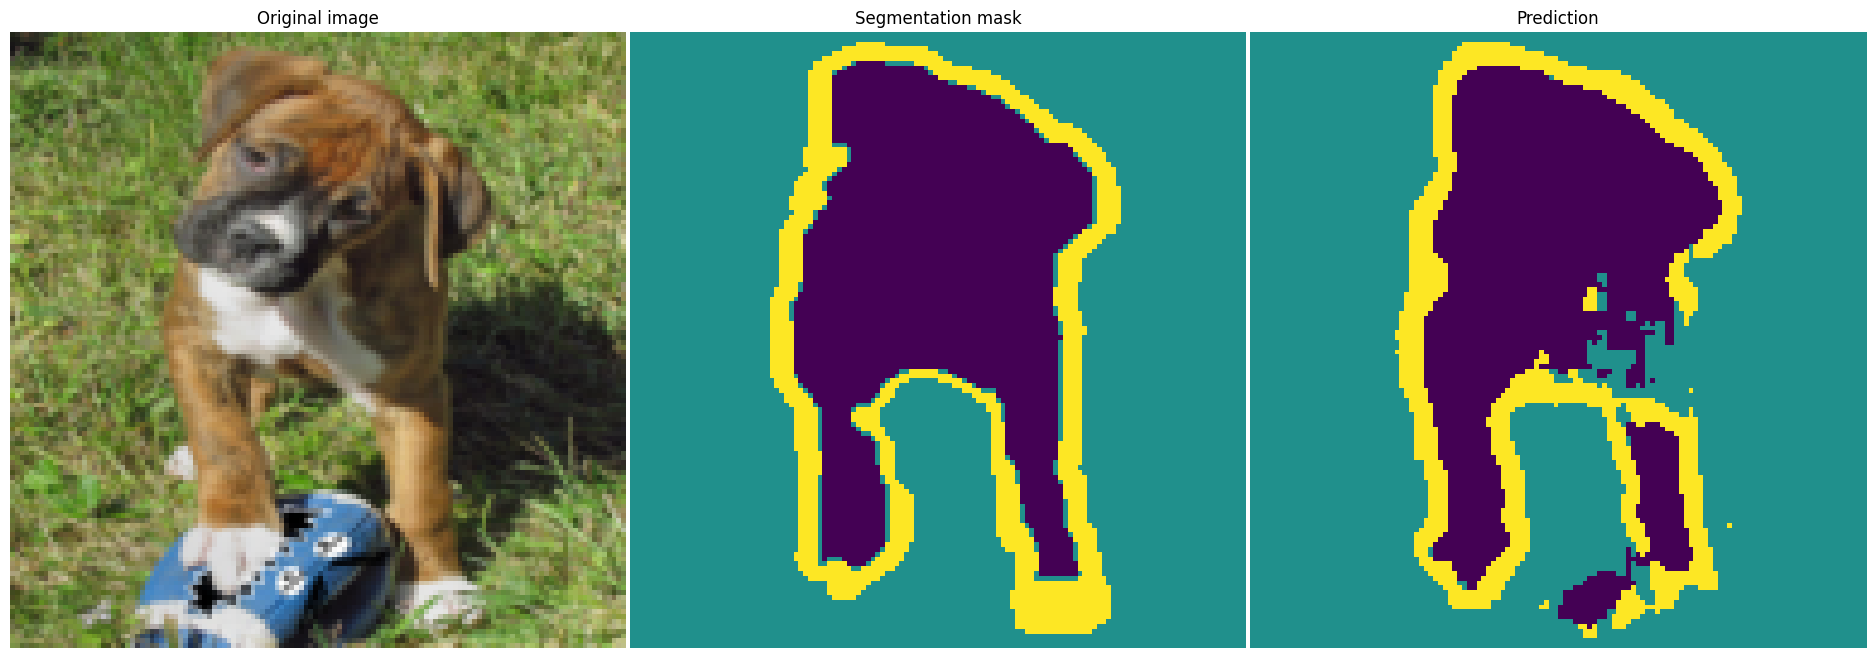

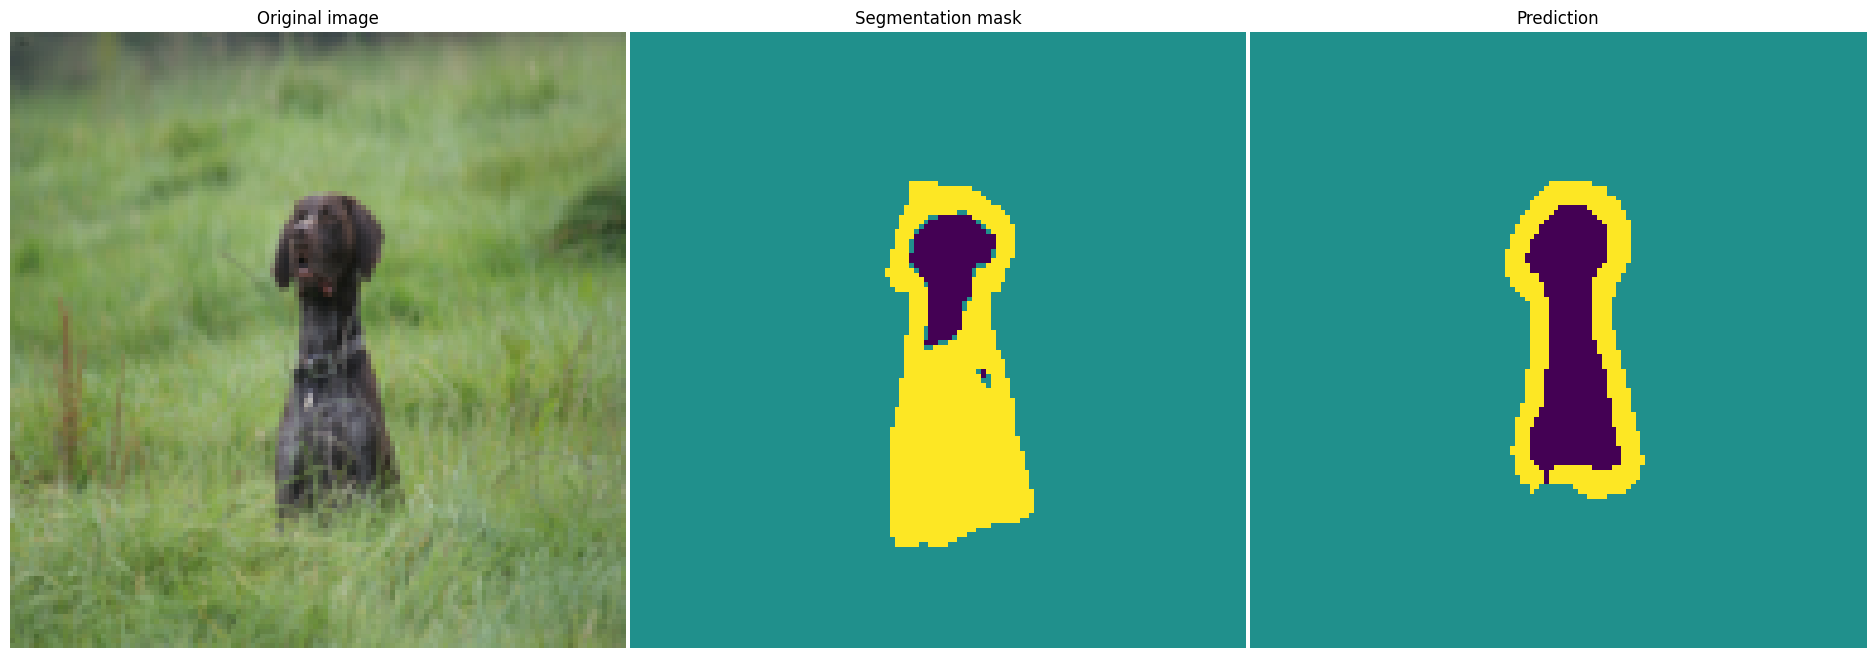

In [21]:
whole_train_valid_cycle(model, 15, 'UNET segmentation')